In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_raw = pd.read_csv("../data/winequality-white.processed.csv")
data_train, data_test = train_test_split(data_raw, test_size=0.2)

scalar = MinMaxScaler()

x_train = data_train.iloc[:, 1 :-2].values
x_train = scalar.fit_transform(x_train)
y_train = data_train[["label"]].values
ymax = y_train.max()
ymin = y_train.min()
y_train = scalar.fit_transform(y_train)

x_test = data_test.iloc[:, 1 :-2].values
x_test = scalar.fit_transform(x_test)
y_test = data_test[["label"]].values
baseline = data_test[["baseline"]].values
#y_test = scalar.fit_transform(y_test)

In [3]:
batch_size = 64

dataloader_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),
                              shuffle=True, batch_size=batch_size)

dataloader_test = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float(), torch.tensor(baseline).float()),
                              shuffle=True, batch_size=batch_size)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
n_bins = 8

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.MLPs = nn.Sequential(
            nn.Linear(n_bins * n_bins + 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        logits = self.MLPs(x)
        return logits
    
model = NeuralNetwork().to(device=device)
print(model)

NeuralNetwork(
  (MLPs): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y, b in dataloader:
            X, y, b = X.to(device), y.to(device), b.to(device)
            pred = model(X)
            pred = pred * (ymax - ymin) + ymin
            test_loss += loss_fn(pred, y).item()
            #qerr += torch.mean(torch.max(pred, y) / torch.min(pred, y))
            #b_qerr += torch.mean(torch.max(b, y) / torch.min(b, y))
    test_loss /= num_batches
    r2 = r2_score(pred.cpu(), y.cpu())
    b_r2 = r2_score(b.cpu(), y.cpu())
    print(f"Test Error: \n R2 Score: {r2:>8f}, Baseline R2 Score: {b_r2:>8f}, Avg loss: {test_loss:>8f} \n")

    return test_loss, r2, b_r2

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
epochs = 500

arr_loss = []
arr_qerr = []
arr_bqerr = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader=dataloader_train, model=model, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, r2, b_r2 = test(dataloader=dataloader_test, model=model, loss_fn=loss_fn)
    arr_loss.append(test_loss)
    arr_qerr.append(r2)
    arr_bqerr.append(b_r2)

print("Done!")

Epoch 1
-------------------------------
loss: 0.435098  [   64/52800]
loss: 0.390978  [ 6464/52800]
loss: 0.252020  [12864/52800]
loss: 0.231386  [19264/52800]
loss: 0.205422  [25664/52800]
loss: 0.194429  [32064/52800]
loss: 0.182303  [38464/52800]
loss: 0.172456  [44864/52800]
loss: 0.166890  [51264/52800]
Test Error: 
 R2 Score: -2186.607048, Baseline R2 Score: 0.995952, Avg loss: 4070078.960145 

Epoch 2
-------------------------------
loss: 0.167175  [   64/52800]
loss: 0.157696  [ 6464/52800]
loss: 0.152456  [12864/52800]
loss: 0.170464  [19264/52800]
loss: 0.153322  [25664/52800]
loss: 0.169828  [32064/52800]
loss: 0.175884  [38464/52800]
loss: 0.202135  [44864/52800]
loss: 0.157896  [51264/52800]
Test Error: 
 R2 Score: -1523.347995, Baseline R2 Score: 0.931141, Avg loss: 3964425.588164 

Epoch 3
-------------------------------
loss: 0.167608  [   64/52800]
loss: 0.175583  [ 6464/52800]
loss: 0.160015  [12864/52800]
loss: 0.165410  [19264/52800]
loss: 0.150218  [25664/52800]
lo

ValueError: x and y must have same first dimension, but have shapes (500,) and (10,)

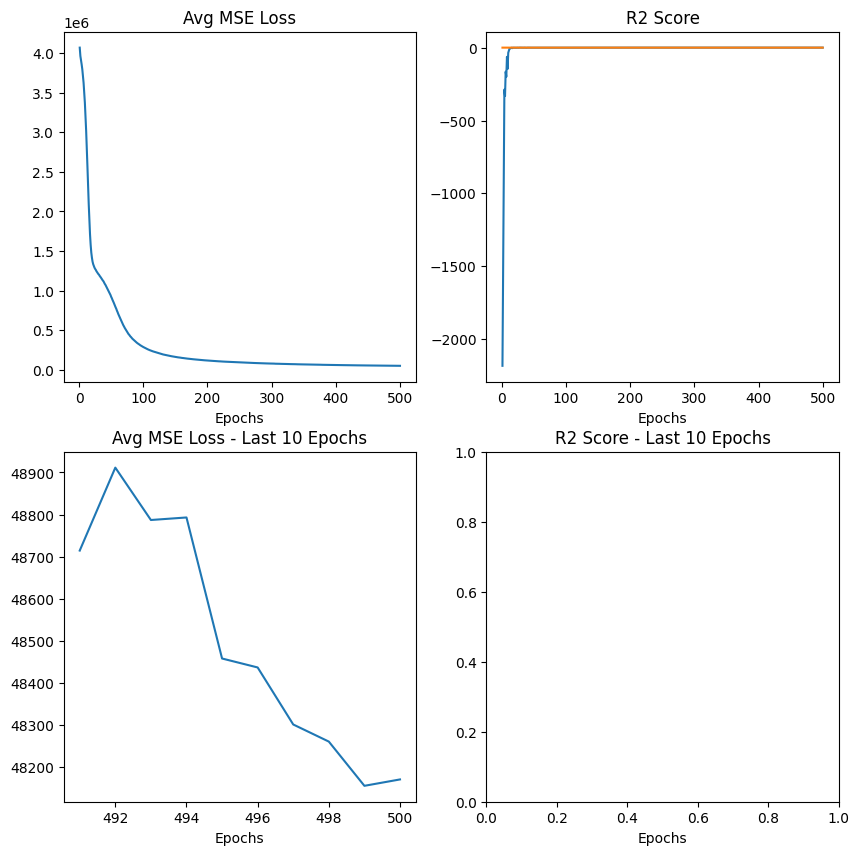

In [10]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axs[0, 0].set_title("Avg MSE Loss")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].plot(range(1, epochs + 1), arr_loss)

axs[0, 1].set_title("R2 Score")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].plot(range(1, epochs + 1), arr_qerr, label="R2 Score")
axs[0, 1].plot(range(1, epochs + 1), arr_bqerr, label="Baseline R2 Score")

axs[1, 0].set_title("Avg MSE Loss - Last 10 Epochs")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].plot(range(epochs - 9, epochs + 1), arr_loss[-10:])

axs[1, 1].set_title("R2 Score - Last 10 Epochs")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].plot(range(epochs - 9, epochs + 1), arr_qerr[-10:], label="R2 Score")
axs[1, 1].plot(range(epochs - 9, epochs + 1), arr_bqerr[-10:], label="Baseline R2 Score")

fig.suptitle("Results")

plt.show()

In [ ]:
baseline